In [8]:
import torch
import pandas as pd
from torch.nn.functional import softmax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from random import randrange
from torch import nn, Tensor
from typing import Iterable, Dict, Callable, Tuple, Union, List
from batchgenerators.transforms.local_transforms import *

[]

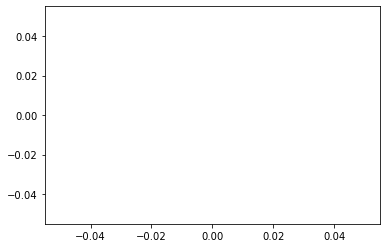

In [9]:
plt.plot()

In [10]:
from nnunet.training.model_restore import restore_model
import batchgenerators
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from batchgenerators.utilities.file_and_folder_operations import *
from nnunet.paths import preprocessing_output_dir
from nnunet.training.dataloading.dataset_loading import *
from nnunet.training.network_training.nnUNetTrainerV2 import nnUNetTrainerV2
from nnunet.run.load_pretrained_weights import load_pretrained_weights

import os, sys
sys.path.append('../')
from dataset import ACDCDataset, MNMDataset
from model.dae import resDAE, AugResDAE
from model.unet import UNet2D



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



# General definitions

In [11]:
class Frankenstein(nn.Module):
    """Wrapper class for segmentation models and feature transformations.

    Wraps (a copy of) the segmentation model and attaches feature
    trasformations to it via hooks (at potentially various positions
    simultaneously). Additionally, it provides control utilities for the
    hooks as well as different types for inference and training.
    """

    def __init__(
        self,
        seg_model: nn.Module,
        transformations: nn.ModuleDict,
        disabled_ids: list = [],
        copy: bool = True,
    ):
        super().__init__()
        self.seg_model = deepcopy(seg_model) if copy else seg_model

        self.transformations = transformations
        self.disabled_ids = disabled_ids
        self.transformation_handles = {}
        self.train_transformation_handles = {}
        self.inspect_transformation_handles = {}
        self.training_data = {}
        self.inspect_data = {}

    def hook_train_transformations(self, transformations: Dict[str, nn.Module]) -> None:
        for layer_id in transformations:
            layer = self.seg_model.get_submodule(layer_id)
            hook = self._get_train_transformation_hook(
                transformations[layer_id], layer_id
            )
            self.train_transformation_handles[
                layer_id
            ] = layer.register_forward_pre_hook(hook)

    def hook_transformations(
        self, transformations: Dict[str, nn.Module], n_samples: int
    ) -> None:
        for layer_id in transformations:
            layer = self.seg_model.get_submodule(layer_id)
            hook = self._get_transformation_hook(transformations[layer_id], n_samples)
            self.transformation_handles[layer_id] = layer.register_forward_pre_hook(
                hook
            )
            
    def hook_inspect_transformation(
        self, 
        transformations: Dict[str, nn.Module], 
        n_samples: int,
        arch: str = 'ae'
    ) -> None:
        for layer_id in transformations:
            if layer_id not in self.disabled_ids:
                layer = self.seg_model.get_submodule(layer_id)
                hook  = self._get_inspect_transformation_hook(transformations[layer_id], layer_id, n_samples, arch)
                self.inspect_transformation_handles[layer_id] = layer.register_forward_pre_hook(hook)
            

    def _get_train_transformation_hook(
        self, transformation: nn.Module, layer_id: str
    ) -> Callable:
        def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
            x_in, *_ = x  # tuple, alternatively use x_in = x[0]
            x_orig = x_in[:1]
            #x_views = x_in[1:]
            x_in_denoised = transformation(x_in)
            if layer_id not in self.disabled_ids:
                mse = nn.functional.mse_loss(x_in_denoised, x_orig.detach(), reduction="mean")

                training_data = {
                    "mse": mse,
                }

                self.training_data[layer_id] = training_data

            return x_in_denoised

        return hook
    

    def _get_transformation_hook(
        self, transformation: nn.Module, n_samples: int = 1
    ) -> Callable:
        def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
            x_in, *_ = x  # weird tuple, can use x_in = x[0]
            if n_samples == 0:
                return x
            elif n_samples == -1:
                x_in_new = transformation(x_in)
                return x_in_new
            else:
                x_in_new = x_in.unsqueeze(1).repeat(1, n_samples, 1, 1, 1).flatten(0, 1)
                x_in_new = transformation(x_in_new)
                return torch.cat([x_in, x_in_new], dim=0)

        return hook
            
        
    def _get_inspect_transformation_hook(
            self, 
            transformation: nn.Module, 
            layer_id: str, 
            n_samples: int,
            arch: str = 'ae',
        ) -> Callable:
        
        @torch.no_grad()
        def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
            x_in, *_ = x  # weird tuple, can use x_in = x[0]
            if n_samples == 0:
                return x
            elif n_samples == -1:
                mu, log_var, x_in_new = transformation(x_in)
            else:
                x_in_new = x_in.unsqueeze(1).repeat(1, n_samples, 1, 1, 1).flatten(0, 1)
                if arch == 'ae':
                    x_in_new = transformation(x_in_new)
                elif arch == 'res_ae':
                    x_in_new, prior, residual = transformation(x_in_new)
                x_in_new = torch.cat([x_in, x_in_new], dim=0)
                
            if layer_id not in self.disabled_ids:
                training_data = {
                    'input'  : x_in_new[ :1],
                    'recon'  : x_in_new[1: ],
                }
                
                if arch == 'res_ae':
                    training_data['prior'] = prior
                    training_data['residual'] = residual
                
                self.inspect_data[layer_id] = training_data
            
            return x_in_new
        
        return hook
   
    

    def remove_train_transformation_hook(self, layer_id: str) -> None:
        self.train_transformation_handles[layer_id].remove()

    def remove_transformation_hook(self, layer_id: str) -> None:
        self.transformation_handles[layer_id].remove()
        
    def remove_inspect_transformation_hook(self, layer_id: str) -> None:
        self.inspect_transformation_handles[layer_id].remove()

    def remove_all_hooks(self):
        if hasattr(self, "train_transformation_handles"):
            for handle in self.train_transformation_handles:
                self.train_transformation_handles[handle].remove()
            self.train_transformation_handles = {}

        if hasattr(self, "transformation_handles"):
            for handle in self.transformation_handles:
                self.transformation_handles[handle].remove()
            self.transformation_handles = {}
            
        if hasattr(self, 'inspect_transformation_handles'):
            for handle in self.inspect_transformation_handles:
                self.inspect_transformation_handles[handle].remove()
            self.inspect_transformation_handles = {}
        

    def freeze_seg_model(self):
        self.seg_model.eval()
        for param in self.seg_model.parameters():
            param.requires_grad = False

    def set_number_of_samples_to(self, n_samples: int):
        self.n_samples = n_samples

    def disable(self, layer_ids: list) -> None:
        for layer_id in layer_ids:
            self.transformations[layer_id].turn_off()

    def enable(self, layer_ids: list) -> None:
        for layer_id in layer_ids:
            self.transformations[layer_id].turn_on()

    def forward(self, x: Tensor):
        return self.seg_model(x)

In [12]:
# define single image dataloader from batchgenerator example here:
# https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/examples/example_ipynb.ipynb
class SingleImageMultiViewDataLoader(batchgenerators.dataloading.data_loader.SlimDataLoaderBase):
    def __init__(self, data: ACDCDataset, batch_size: int = 2, return_orig: str = False):
        super(SingleImageMultiViewDataLoader, self).__init__(data, batch_size)
        # data is now stored in self._data.
        self.return_orig = return_orig
    
    def generate_train_batch(self):
        
        data = self._data[randrange(len(self._data))]
        img = data['input'].numpy().astype(np.float32)
        tar = data['target'][0].numpy().astype(np.float32)
        
        img_batched = np.tile(img, (self.batch_size, 1, 1, 1))
        tar_batched = np.tile(tar, (self.batch_size, 1, 1, 1))
        # now construct the dictionary and return it. np.float32 cast because most networks take float
        out = {'data': img_batched, 
               'seg':  tar_batched}
        
        # if the original data is also needed, activate this flag to store it where augmentations
        # cant find it.
        if self.return_orig:
            out['data_orig']   = data['input'].unsqueeze(0)
            out['target_orig'] = data['target'].unsqueeze(0)
        
        return out
    
    
class LayerAugDiff(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        measure: str = 'std',
        copy: bool = True
    ):
        super().__init__()
        self.model   = deepcopy(model) if copy else model
        self.measure = measure
        # init container for data and hook handles
        self.layer_ids = []
        self.handles   = {}
        self.diffs     = {}
        # filter modules for layers that are particular interesting
        # hint: modify get_layer_ids for alternative filter
        self.get_layer_ids()
        # init forward (after) hooks to collect data later. Hooks
        # are manageable via self.handles
        self.hook_hooks()
        
        
    def get_layer_ids(self) -> None:
        # Get all BN layers
        for name, module in self.model.named_modules():
            #if '.bn' in name:
            #if 'down1.2' in name:
            if name.count('.') == 1:
                self.layer_ids.append(name)      
                
        
    def hook_hooks(self) -> None:
        for layer_id in self.layer_ids:
            # get module for layer id to hook onto
            layer = self.model.get_submodule(layer_id)
            # build hook for this layer with function above
            hook = self._get_hook(layer_id)
            # hook hook and save handle to interact with it later
            self.handles[layer_id] = layer.register_forward_hook(hook)
            
            
    @torch.no_grad()
    def _get_hook(self, layer_id: str) -> Callable:
        def hook(module: nn.Module, x_in: Tuple[Tensor], x_out: Tuple[Tensor]) -> Tensor:
            #print(x_out.shape)
            #x, *_ = x_out  # tuple, alternatively use x_in = x[0]
            #print(x_in[0].shape, x_out.shape)
            
            # calculates mean std across inputs with different augmentations
            if self.measure == 'std':
                diff = x_out.std(0).mean().item()
            # calculate activation normalized MSE
            elif self.measure == 'mse':
                mse = torch.pow(
                    x_out[:1] - x_out[1:],
                    2
                ).mean()
                diff = mse / torch.abs(x_out[:1]).mean()
                diff = torch.clamp(diff, 0, 2)
            # appends diff to list for each layer. Inits list if doesn't exist
            self.diffs.setdefault(layer_id, []).append(diff.detach().cpu().item())
            return x_out
        return hook
    
    
    def forward(self, x: Tensor):
        return self.model(x)





# Plotting 

In [ ]:
def plot_layer_diff(
    scanner: str, 
    augmentations: str, 
    scaled: bool, 
    n_views: int = 32, 
    n_imgs: int = 250, 
    unet_id: str = 0
):
    
#     
#     augmentations = 'output_invariant'  
#     scaled = False
#     n_views = 4
#     n_imgs = 100
#     unet_id = 0

    ### - build augmentator
    # where data is saved
    nnUnet_prefix = '../../../nnUNet/'
    # Initialize trainer to get data loaders with data augmentations from training
    pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
    fold              = 0
    output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
    dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'
    trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
    trainer.initialize()
    train_loader = trainer.tr_gen
    # filter augmentations w.r.t. given keyword and init augmentor
    if augmentations == 'all':
        transforms = [t for t in train_loader.transform.transforms]
    elif augmentations == 'output_invariant':
        data_only_transforms = (
            batchgenerators.transforms.resample_transforms.SimulateLowResolutionTransform,
            batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
            batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
            batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
            batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
            batchgenerators.transforms.color_transforms.GammaTransform,
            batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
            batchgenerators.transforms.utility_transforms.RenameTransform,
            batchgenerators.transforms.utility_transforms.NumpyToTensor)

        transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
    augmentor  = batchgenerators.transforms.abstract_transforms.Compose(transforms)

    ### - Load dataset and init batch generator
    if scanner in ['train', 'val']:
        data = ACDCDataset(data=scanner, debug=False)
    elif scanner in ['A', 'B', 'C', 'D']:
        data = MNMDataset(vendor=scanner, debug=False)
    gen = SingleImageMultiViewDataLoader(data, batch_size=n_views, return_orig=True)
    multithreaded_gen = MultiThreadedAugmenter(gen, augmentor, 1, 1, seeds=None)

    ### - Init Model and hook feature extractors
    root = '../../'
    middle = 'unet8_'
    pre = 'acdc'
    name = f'{pre}_{middle}{unet_id}'

    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    unet.load_state_dict(state_dict)
    model = LayerAugDiff(unet, measure='mse', copy=True)
    model.eval()
    model.to(0)

    ### - gather diffs across all inputs with their respective views
    for i in range(n_imgs):
        batch = multithreaded_gen.next()
        input_ = torch.cat([batch['data_orig'], batch['data']], dim=0)
        input_mse = torch.pow(
                        input_[:1] - input_[1:],
                        2
                    ).mean()
        input_mse /=  torch.abs(input_[:1]).mean()
        model.diffs.setdefault('Augmented Input', []).append(input_mse.item())
        output = softmax(model(input_.cuda()), dim=1).detach().cpu()
        output_mse = torch.pow(
                        output[:1] - output[1:],
                        2
                    ).mean()
        output_mse = output_mse / torch.abs(output[:1]).mean()
        model.diffs.setdefault('Softmax Output', []).append(output_mse.item())

    ### - build dataframe for plotting
    df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])
    for i, key in enumerate(model.diffs):
        entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
        df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])

    ### - build plot
    sns.set(rc={'figure.figsize':(30,15)})
    g = sns.boxplot(
        data=df_diffs, 
        x='layer', 
        y='diff', 
    )
    
    if scaled:
        g.set(ylim=(-0.1, 1.3))
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=90)

    if augmentations == 'all':
        aug_str = 'all'
    elif augmentations == 'output_invariant':
        aug_str = 'output-invariant'

    title = f"Normalized MSE to Original per Layer for identical Inputs with {aug_str} Augmentations - Data {scanner.upper()}"
    plt.title(title, fontsize = 30)
    plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
    plt.xlabel("Layer", fontsize=20)
    save_path = f"../../results-tmp/results/eval/variations-across-layers_MSE_{aug_str}_{scanner}_{'scaled' if scaled else 'unscaled'}_{unet_id}_filtertest.jpg"
    print(save_path)
    plt.savefig(save_path, bbox_inches='tight', dpi=400)
    plt.show()
    plt.close()

In [ ]:
plot_layer_diff(scanner='train', augmentations='output_invariant', scaled=False, unet_id=0)

In [17]:
def plot_layer_diff(
    scanner: str, 
    augmentations: str, 
    scaled: bool, 
    n_views: int = 32, 
    n_imgs: int = 250, 
    unet_id: str = 0
):
    
#     
#     augmentations = 'output_invariant'  
#     scaled = False
#     n_views = 4
#     n_imgs = 100
#     unet_id = 0
    scanner = 'train'
    ### - build augmentator
    # where data is saved
    nnUnet_prefix = '../../../nnUNet/'
    # Initialize trainer to get data loaders with data augmentations from training
    pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
    fold              = 0
    output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
    dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'
    trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
    trainer.initialize()
    train_loader = trainer.tr_gen
    # filter augmentations w.r.t. given keyword and init augmentor
    if augmentations == 'all':
        transforms = [t for t in train_loader.transform.transforms]
    elif augmentations == 'output_invariant':
        data_only_transforms = (
            batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
            batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
            batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
            batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
            batchgenerators.transforms.color_transforms.GammaTransform,
            batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
            batchgenerators.transforms.utility_transforms.RenameTransform,
            batchgenerators.transforms.utility_transforms.NumpyToTensor)

        transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
    augmentor  = batchgenerators.transforms.abstract_transforms.Compose(transforms)

    ### - Load dataset and init batch generator
    if scanner in ['train', 'val']:
        data = ACDCDataset(data=scanner, debug=False)
    elif scanner in ['A', 'B', 'C', 'D']:
        data = MNMDataset(vendor=scanner, debug=False)
    gen = SingleImageMultiViewDataLoader(data, batch_size=n_views, return_orig=True)
    multithreaded_gen = MultiThreadedAugmenter(gen, augmentor, 1, 1, seeds=None)

    ### - Init Model and hook feature extractors
    root = '../../'
    middle = 'unet8_'
    pre = 'acdc'
    name = f'{pre}_{middle}{unet_id}'

    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    # unet.load_state_dict(state_dict)
    model = LayerAugDiff(unet, measure='mse', copy=True)
    model.eval()
    model.to(0)

    ### - gather diffs across all inputs with their respective views
    for i in range(n_imgs):
        batch = multithreaded_gen.next()
        input_ = torch.cat([batch['data_orig'], batch['data']], dim=0)
        input_mse = torch.pow(
                        input_[:1] - input_[1:],
                        2
                    ).mean()
        input_mse /=  torch.abs(input_[:1]).mean()
        model.diffs.setdefault('Augmented Input', []).append(input_mse.item())
        output = softmax(model(input_.cuda()), dim=1).detach().cpu()
        output_mse = torch.pow(
                        output[:1] - output[1:],
                        2
                    ).mean()
        output_mse = output_mse / torch.abs(output[:1]).mean()
        model.diffs.setdefault('Softmax Output', []).append(output_mse.item())

    ### - build dataframe for plotting
    df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])
    for i, key in enumerate(model.diffs):
        entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
        df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])

    ### - build plot
    sns.set(rc={'figure.figsize':(30,15)})
    g = sns.boxplot(
        data=df_diffs, 
        x='layer', 
        y='diff', 
        showfliers=False, 
        showcaps=False, 
        showbox=False,
        whis=0,
        medianprops=dict(color='blue')
    )
    
    if scaled:
        g.set(ylim=(-0.1, 1.3))
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=90)

    if augmentations == 'all':
        aug_str = 'all'
    elif augmentations == 'output_invariant':
        aug_str = 'output-invariant'

    title = f"Normalized MSE to Original per Layer for identical Inputs with {aug_str} Augmentations - Data {scanner.upper()}"
    plt.title(title, fontsize = 30)
    plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
    plt.xlabel("Layer", fontsize=20)
    save_path = f"../../results-tmp/results/eval/variations-across-layers_MSE_{aug_str}_{scanner}_{'scaled' if scaled else 'unscaled'}_{unet_id}.jpg"
    print(save_path)
    #plt.savefig(save_path, bbox_inches='tight', dpi=400)
    #plt.show()

    scanner = 'A'
    ### - build augmentator
    # where data is saved
    nnUnet_prefix = '../../../nnUNet/'
    # Initialize trainer to get data loaders with data augmentations from training
    pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
    fold              = 0
    output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
    dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'
    trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
    trainer.initialize()
    train_loader = trainer.tr_gen
    # filter augmentations w.r.t. given keyword and init augmentor
    if augmentations == 'all':
        transforms = [t for t in train_loader.transform.transforms]
    elif augmentations == 'output_invariant':
        data_only_transforms = (
            batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
            batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
            batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
            batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
            batchgenerators.transforms.color_transforms.GammaTransform,
            batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
            batchgenerators.transforms.utility_transforms.RenameTransform,
            batchgenerators.transforms.utility_transforms.NumpyToTensor)

        transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
    augmentor  = batchgenerators.transforms.abstract_transforms.Compose(transforms)

    ### - Load dataset and init batch generator
    if scanner in ['train', 'val']:
        data = ACDCDataset(data=scanner, debug=False)
    elif scanner in ['A', 'B', 'C', 'D']:
        data = MNMDataset(vendor=scanner, debug=False)
    gen = SingleImageMultiViewDataLoader(data, batch_size=n_views, return_orig=True)
    multithreaded_gen = MultiThreadedAugmenter(gen, augmentor, 1, 1, seeds=None)

    ### - Init Model and hook feature extractors
    root = '../../'
    middle = 'unet8_'
    pre = 'acdc'
    name = f'{pre}_{middle}{unet_id}'

    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    #unet.load_state_dict(state_dict)
    model = LayerAugDiff(unet, measure='mse', copy=True)
    model.eval()
    model.to(0)

    ### - gather diffs across all inputs with their respective views
    for i in range(n_imgs):
        batch = multithreaded_gen.next()
        input_ = torch.cat([batch['data_orig'], batch['data']], dim=0)
        input_mse = torch.pow(
                        input_[:1] - input_[1:],
                        2
                    ).mean()
        input_mse /=  torch.abs(input_[:1]).mean()
        model.diffs.setdefault('Augmented Input', []).append(input_mse.item())
        output = softmax(model(input_.cuda()), dim=1).detach().cpu()
        output_mse = torch.pow(
                        output[:1] - output[1:],
                        2
                    ).mean()
        output_mse = output_mse / torch.abs(output[:1]).mean()
        model.diffs.setdefault('Softmax Output', []).append(output_mse.item())

    ### - build dataframe for plotting
    df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])
    for i, key in enumerate(model.diffs):
        entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
        df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])

    ### - build plot
    sns.set(rc={'figure.figsize':(30,15)})
    g = sns.boxplot(
        data=df_diffs, 
        x='layer', 
        y='diff', 
        showfliers=False, 
        showcaps=False, 
        showbox=False,
        whis=0,
        medianprops=dict(color='red')
    )
    
    if scaled:
        g.set(ylim=(-0.1, 1.3))
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=90)

    if augmentations == 'all':
        aug_str = 'all'
    elif augmentations == 'output_invariant':
        aug_str = 'output-invariant'

    title = f"Normalized MSE to Original per Layer for identical Inputs with {aug_str} Augmentations - Comparison Train vs Test"
    plt.title(title, fontsize = 30)
    plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
    plt.xlabel("Layer", fontsize=20)
    save_path = f"../../results-tmp/results/eval/variations-across-layers_MSE_{aug_str}_{scanner}_{'scaled' if scaled else 'unscaled'}_{unet_id}_untrained.jpg"
    print(save_path)
    plt.savefig(save_path, bbox_inches='tight', dpi=400)
    plt.show()
    plt.close()

In [18]:
plot_layer_diff(scanner='A', augmentations='output_invariant', scaled=False, unet_id=0)

loading dataset
loading all case properties
2023-08-22 15:40:14.053583: Using splits from existing split file: ../../../nnUNet/data/nnUNet_preprocessed/Task500_ACDC/splits_final.pkl
2023-08-22 15:40:14.054868: The split file contains 5 splits.
2023-08-22 15:40:14.054999: Desired fold for training: 0
2023-08-22 15:40:14.055536: This split has 160 training and 40 validation cases.
unpacking dataset
done
loading dataset
loading all case properties
../../results-tmp/results/eval/variations-across-layers_MSE_output-invariant_train_unscaled_0.jpg
loading dataset
loading all case properties
2023-08-22 15:40:53.650719: Using splits from existing split file: ../../../nnUNet/data/nnUNet_preprocessed/Task500_ACDC/splits_final.pkl
2023-08-22 15:40:53.651926: The split file contains 5 splits.
2023-08-22 15:40:53.652286: Desired fold for training: 0
2023-08-22 15:40:53.652864: This split has 160 training and 40 validation cases.
unpacking dataset
done
loading dataset
loading all case properties
../.

In [15]:
def plot_layer_diff(
    scanner: str, 
    augmentations: str, 
    scaled: bool, 
    n_views: int = 32, 
    n_imgs: int = 100, 
    unet_id: str = 0
):
    
#     
#     augmentations = 'output_invariant'  
#     scaled = False
#     n_views = 4
#     n_imgs = 100
#     unet_id = 0



    scanner = 'train'
    ### - build augmentator
    # where data is saved
    nnUnet_prefix = '../../../nnUNet/'
    # Initialize trainer to get data loaders with data augmentations from training
    pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
    fold              = 0
    output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
    dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'
    trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
    trainer.initialize()
    train_loader = trainer.tr_gen
    # filter augmentations w.r.t. given keyword and init augmentor
    if augmentations == 'all':
        transforms = [t for t in train_loader.transform.transforms]
    elif augmentations == 'output_invariant':
        data_only_transforms = (
            batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
            batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
            batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
            batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
            batchgenerators.transforms.color_transforms.GammaTransform,
            batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
            batchgenerators.transforms.utility_transforms.RenameTransform,
            batchgenerators.transforms.utility_transforms.NumpyToTensor)

        transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
    augmentor  = batchgenerators.transforms.abstract_transforms.Compose(transforms)

    ### - Load dataset and init batch generator
    if scanner in ['train', 'val']:
        data = ACDCDataset(data=scanner, debug=False)
    elif scanner in ['A', 'B', 'C', 'D']:
        data = MNMDataset(vendor=scanner, debug=False)
    gen = SingleImageMultiViewDataLoader(data, batch_size=n_views, return_orig=True)
    multithreaded_gen = MultiThreadedAugmenter(gen, augmentor, 1, 1, seeds=None)

    ### - Init Model and hook feature extractors
    root = '../../'
    middle = 'unet8_'
    pre = 'acdc'
    name = f'{pre}_{middle}{unet_id}'

    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    #unet.load_state_dict(state_dict)
    model = LayerAugDiff(unet, measure='mse', copy=True)
    model.eval()
    model.to(0)

    ### - gather diffs across all inputs with their respective views
    for i in range(n_imgs):
        batch = multithreaded_gen.next()
        input_ = torch.cat([batch['data_orig'], batch['data']], dim=0)
        input_mse = torch.pow(
                        input_[:1] - input_[1:],
                        2
                    ).mean()
        input_mse /=  torch.abs(input_[:1]).mean()
        model.diffs.setdefault('Augmented Input', []).append(input_mse.item())
        output = softmax(model(input_.cuda()), dim=1).detach().cpu()
        output_mse = torch.pow(
                        output[:1] - output[1:],
                        2
                    ).mean()
        output_mse = output_mse / torch.abs(output[:1]).mean()
        model.diffs.setdefault('Softmax Output', []).append(output_mse.item())

    ### - build dataframe for plotting
    df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])
    for i, key in enumerate(model.diffs):
        entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
        df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])

    ### - build plot
    sns.set(rc={'figure.figsize':(30,15)})
    g = sns.boxplot(
        data=df_diffs, 
        x='layer', 
        y='diff', 
        showfliers=False, 
        showcaps=False, 
        showbox=False,
        whis=0,
        medianprops=dict(color='blue')
    )
    
    if scaled:
        g.set(ylim=(-0.1, 1.3))
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=90)

    if augmentations == 'all':
        aug_str = 'all'
    elif augmentations == 'output_invariant':
        aug_str = 'output-invariant'

    title = f"Normalized MSE to Original per Layer for identical Inputs with {aug_str} Augmentations - Data {scanner.upper()}"
    plt.title(title, fontsize = 30)
    plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
    plt.xlabel("Layer", fontsize=20)
    save_path = f"../../results-tmp/results/eval/variations-across-layers_MSE_{aug_str}_{scanner}_{'scaled' if scaled else 'unscaled'}_{unet_id}.jpg"
    print(save_path)
    #plt.savefig(save_path, bbox_inches='tight', dpi=400)
    #plt.show()

    scanner = 'C'
    ### - build augmentator
    # where data is saved
    nnUnet_prefix = '../../../nnUNet/'
    # Initialize trainer to get data loaders with data augmentations from training
    pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
    fold              = 0
    output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
    dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'
    trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
    trainer.initialize()
    train_loader = trainer.tr_gen
    # filter augmentations w.r.t. given keyword and init augmentor
    if augmentations == 'all':
        transforms = [t for t in train_loader.transform.transforms]
    elif augmentations == 'output_invariant':
        data_only_transforms = (
            batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
            batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
            batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
            batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
            batchgenerators.transforms.color_transforms.GammaTransform,
            batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
            batchgenerators.transforms.utility_transforms.RenameTransform,
            batchgenerators.transforms.utility_transforms.NumpyToTensor)

        transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
    augmentor  = batchgenerators.transforms.abstract_transforms.Compose(transforms)

    ### - Load dataset and init batch generator
    if scanner in ['train', 'val']:
        data = ACDCDataset(data=scanner, debug=False)
    elif scanner in ['A', 'B', 'C', 'D']:
        data = MNMDataset(vendor=scanner, debug=False)
    gen = SingleImageMultiViewDataLoader(data, batch_size=n_views, return_orig=True)
    multithreaded_gen = MultiThreadedAugmenter(gen, augmentor, 1, 1, seeds=None)

    ### - Init Model and hook feature extractors
    root = '../../'
    middle = 'unet8_'
    pre = 'acdc'
    name = f'{pre}_{middle}{unet_id}'

    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    #unet.load_state_dict(state_dict)
    model_aug_hooks = LayerAugDiff(unet, measure='mse', copy=True)
    
    disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
    DAEs = nn.ModuleDict({'up3': AugResDAE(in_channels = 64, 
                                        in_dim      = 32,
                                        latent_dim  = 128,
                                        depth       = 3,
                                        block_size  = 1)})


    for layer_id in disabled_ids:
        DAEs[layer_id] = nn.Identity()

    transformer = Frankenstein(seg_model=unet,
                         transformations=DAEs,
                         disabled_ids=disabled_ids,
                         copy=True)

    model_path = f'{root}pre-trained-tmp/trained_AEs/acdc_AugResDAE{unet_id}_base_best.pt'    
    state_dict = torch.load(model_path)['model_state_dict']
    transformer.load_state_dict(state_dict)
    
    #model.seg_model = model_aug_hooks
    transformer.hook_transformations(transformer.transformations, n_samples=-1)
    transformer.seg_model.load_state_dict(unet.state_dict())
    model = LayerAugDiff(transformer.seg_model, measure='mse', copy=False)
    
    model.eval()
    model.to(0)
    
    transformer.eval()
    transformer.to(0)
    ### - gather diffs across all inputs with their respective views
    for i in range(n_imgs):
        batch = multithreaded_gen.next()
        input_ = torch.cat([batch['data_orig'], batch['data']], dim=0)
        input_mse = torch.pow(
                        input_[:1] - input_[1:],
                        2
                    ).mean()
        input_mse /=  torch.abs(input_[:1]).mean()
        model.diffs.setdefault('Augmented Input', []).append(input_mse.item())
        output = softmax(model(input_.cuda()), dim=1).detach().cpu()
        output_mse = torch.pow(
                        output[:1] - output[1:],
                        2
                    ).mean()
        output_mse = output_mse / torch.abs(output[:1]).mean()
        model.diffs.setdefault('Softmax Output', []).append(output_mse.item())

    ### - build dataframe for plotting
    df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])
    for i, key in enumerate(model.diffs):
        entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
        df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])

    ### - build plot
    sns.set(rc={'figure.figsize':(30,15)})
    g = sns.boxplot(
        data=df_diffs, 
        x='layer', 
        y='diff', 
        showfliers=False, 
        showcaps=False, 
        showbox=False,
        whis=0,
        medianprops=dict(color='red')
    )
    
    if scaled:
        g.set(ylim=(-0.1, 1.3))
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=90)

    if augmentations == 'all':
        aug_str = 'all'
    elif augmentations == 'output_invariant':
        aug_str = 'output-invariant'

    title = f"Normalized MSE to Original per Layer for identical Inputs with {aug_str} Augmentations - Data {scanner.upper()}"
    plt.title(title, fontsize = 30)
    plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
    plt.xlabel("Layer", fontsize=20)
    save_path = f"../../results-tmp/results/eval/variations-across-layers_MSE_{aug_str}_{scanner}_{'scaled' if scaled else 'unscaled'}_{unet_id}_untrained.jpg"
    print(save_path)
    plt.savefig(save_path, bbox_inches='tight', dpi=400)
    plt.show()
    plt.close()

In [16]:
plot_layer_diff(scanner='C', augmentations='output_invariant', scaled=False, unet_id=0)

loading dataset
loading all case properties
2023-08-22 15:38:02.746119: Using splits from existing split file: ../../../nnUNet/data/nnUNet_preprocessed/Task500_ACDC/splits_final.pkl
2023-08-22 15:38:02.747222: The split file contains 5 splits.
2023-08-22 15:38:02.747377: Desired fold for training: 0
2023-08-22 15:38:02.747958: This split has 160 training and 40 validation cases.
unpacking dataset
done
loading dataset
loading all case properties
../../results-tmp/results/eval/variations-across-layers_MSE_output-invariant_train_unscaled_0.jpg
loading dataset
loading all case properties
2023-08-22 15:38:21.807901: Using splits from existing split file: ../../../nnUNet/data/nnUNet_preprocessed/Task500_ACDC/splits_final.pkl
2023-08-22 15:38:21.808832: The split file contains 5 splits.
2023-08-22 15:38:21.809078: Desired fold for training: 0
2023-08-22 15:38:21.809476: This split has 160 training and 40 validation cases.
unpacking dataset
done
loading dataset
loading all case properties
../.

In [ ]:
def plot_layer_diff(
    scanner: str, 
    augmentations: str, 
    scaled: bool, 
    n_views: int = 32, 
    n_imgs: int = 100, 
    unet_id: str = 0
):
    ### - build augmentator
    # where data is saved
    nnUnet_prefix = '../../../nnUNet/'
    # Initialize trainer to get data loaders with data augmentations from training
    pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
    fold              = 0
    output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
    dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'
    trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
    trainer.initialize()
    train_loader = trainer.tr_gen
    # filter augmentations w.r.t. given keyword and init augmentor
    if augmentations == 'all':
        transforms = [t for t in train_loader.transform.transforms]
    elif augmentations == 'output_invariant':
        data_only_transforms = (
            batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
            batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
            batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
            batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
            batchgenerators.transforms.color_transforms.GammaTransform,
            batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
            batchgenerators.transforms.utility_transforms.RenameTransform,
            batchgenerators.transforms.utility_transforms.NumpyToTensor,
            batchgenerators.transforms.utility_transforms.NumpyToTensor)
        
        transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
    augmentor  = batchgenerators.transforms.abstract_transforms.Compose(transforms)
    
    ### - Load dataset and init batch generator
    if scanner in ['train', 'val']:
        data = ACDCDataset(data=scanner, debug=False)
    elif scanner in ['A', 'B', 'C', 'D']:
        data = MNMDataset(vendor=scanner, debug=False)
    gen = SingleImageMultiViewDataLoader(data, batch_size=n_views)
    multithreaded_gen = MultiThreadedAugmenter(gen, augmentor, 4, 2, seeds=None)
    
    ### - Init Model and hook feature extractors
    root = '../../'
    middle = 'unet8_'
    pre = 'acdc'
    name = f'{pre}_{middle}{unet_id}'

    model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    unet.load_state_dict(state_dict)
    model = LayerAugDiff(unet, copy=True)
    model.eval()
    model.to(0)
    
    ### - gather diffs across all inputs with their respective views
    for i in range(n_imgs):
        batch = multithreaded_gen.next()
        model.diffs.setdefault('Augmented Input', []).append(batch['data'].std(0).mean().item())
        out = model(batch['data'].cuda())
        model.diffs.setdefault('Softmax Output', []).append(softmax(out, dim=1).std(0).mean().item())
    
    ### - build dataframe for plotting
    df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])
    for i, key in enumerate(model.diffs):
        entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
        df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])
    
    ### - build plot
    sns.set(rc={'figure.figsize':(30,15)})
    g = sns.boxplot(data=df_diffs, x='layer', y='diff')
    if scaled:
        g.set(ylim=(-0.1, 1.3))
    sns.despine(offset=10, trim=True)
    plt.xticks(rotation=90)
    
    if augmentations == 'all':
        aug_str = 'all'
    elif augmentations == 'output_invariant':
        aug_str = 'output-invariant'
        
    title = f"Variation per BN-Layer for identical Inputs with {aug_str} Augmentations - Data {scanner.upper()}"
    plt.title(title, fontsize = 30)
    plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
    plt.xlabel("Layer", fontsize=20)
    save_path = f"../../results-tmp/results/eval/variations-across-layers_{aug_str}_{scanner}_{'scaled' if scaled else 'unscaled'}_{unet_id}.jpg"
    print(save_path)
    #plt.savefig(save_path, bbox_inches='tight', dpi=400)
    plt.show()
    #plt.close()

In [ ]:
plot_layer_diff(scanner='train', augmentations='output_invariant', scaled=False, unet_id=0)

In [ ]:
for scanner in ['train', 'val', 'A', 'B', 'C', 'D']:
    for augmentations in ['all', 'output_invariant']:
        for scaled in [True, False]:
            for unet_id in [0, 1]:
                plot_layer_diff(scanner=scanner, augmentations=augmentations, scaled=scaled, unet_id=unet_id)

In [ ]:
src/demos/OT.ipynb

# Drafting Ideas

## Load existing trainer to reproduce augmentations

In [ ]:
## where data is saved
nnUnet_prefix = '../../../nnUNet/'

## Initialize trainer to get data loaders with data augmentations from training
pkl_file          = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC/nnUNetPlansv2.1_plans_2D.pkl'
fold              = 0
output_folder     = nnUnet_prefix + 'results/nnUnet/nnUNet/2d/Task027_ACDC/nnUNetTrainerV2__nnUNetPlansv2.1/'
dataset_directory = nnUnet_prefix + 'data/nnUNet_preprocessed/Task500_ACDC'

trainer = nnUNetTrainerV2(pkl_file, 0, output_folder, dataset_directory)
trainer.initialize()

train_loader = trainer.tr_gen

## Extract augmentations and re-build augmentater

In [ ]:
train_loader.transform

In [ ]:

# Collect all transforms that only impact the input, not the segmentation mask
data_only_transforms = (
    batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
    batchgenerators.transforms.noise_transforms.GaussianBlurTransform,
    batchgenerators.transforms.color_transforms.BrightnessMultiplicativeTransform,
    batchgenerators.transforms.color_transforms.ContrastAugmentationTransform,
    batchgenerators.transforms.color_transforms.GammaTransform,
    batchgenerators.transforms.utility_transforms.NumpyToTensor
    )

# Filter transforms for input-only augmentations and build an augmenter
#transforms = [t for t in train_loader.transform.transforms if isinstance(t, data_only_transforms)]
transforms = [t for t in train_loader.transform.transforms]
augmenter  = batchgenerators.transforms.abstract_transforms.Compose(transforms)

## Custom Dataloader for single-image multi-view

In [ ]:
# define single image dataloader from batchgenerator example here:
# https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/examples/example_ipynb.ipynb
class DataLoader(batchgenerators.dataloading.data_loader.SlimDataLoaderBase):
    def __init__(self, data, batch_size=2):
        super(DataLoader, self).__init__(data, batch_size) 
        # data is now stored in self._data.
    
    def generate_train_batch(self):
        # usually you would now select random instances of your data. We only have one therefore we skip this
        
        data = self._data[randrange(len(self._data))]
        img = data['input'].numpy()
        tar = data['target'].numpy()
        
        
        # The camera image has only one channel. Our batch layout must be (b, c, x, y). Let's fix that
        img = np.tile(img, (self.batch_size, 1, 1, 1))
        tar = np.tile(tar, (self.batch_size, 1, 1, 1))
        # now construct the dictionary and return it. np.float32 cast because most networks take float
        return {'data':img.astype(np.float32), 
                'target': tar.astype(np.float32), 
                'seg': tar.astype(np.float32), 'some_other_key':'some other value'}



## Load data and init generator

In [ ]:
#test_set = ACDCDataset(data='train', debug=True)
test_set = MNMDataset(vendor='D', debug=False)
#acdc_train_loader = DataLoader(acdc_train, batch_size=32, shuffle=False, drop_last=False)
#loader['acdc_train'] = acdc_train_loader

In [ ]:
batchgen = DataLoader(test_set, batch_size=5)

In [ ]:
multithreaded_generator = batchgenerators.dataloading.multi_threaded_augmenter.MultiThreadedAugmenter(batchgen, augmenter, 4, 2, seeds=None)

## Testing

In [ ]:
def plot_batch(batch):
    batch_size = batch['data'].shape[0]
    plt.figure(figsize=(16, 10))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(batch['data'][i, 0], cmap="gray") # only grayscale image here
    plt.show()
plot_batch(multithreaded_generator.next())
plt.show()

In [ ]:
batch = multithreaded_generator.next()

In [ ]:
plt.imshow(batch['data'].std((0,1)))

## U-Net and hooks

In [ ]:
root = '../../'
middle = 'unet8_'
pre = 'acdc'
name = f'{pre}_{middle}0'

model_path = f'{root}pre-trained-tmp/trained_UNets/{name}_best.pt'
state_dict = torch.load(model_path)['model_state_dict']
n_chans_out = 4
unet = UNet2D(n_chans_in=1, 
              n_chans_out=n_chans_out, 
              n_filters_init=8, 
              dropout=False)
unet.load_state_dict(state_dict)

In [ ]:
## Find layer names to attach hooks to. We aim to attach after
## each BN layer. This way, aggregate metrics are comparable
## up until normalization issues

### Does it make sense? Do BN Layers delete any signal?
for name, module in unet.named_modules():
    if '.bn' in name:
        print(name)
    if name == 'init_path.4.conv_path.1.bn':
        break

In [ ]:
model = LayerAugDiff(unet, copy=True)
model.eval()
model.to(0)
print()

In [ ]:
batchgen = DataLoader(test_set, batch_size=32)

In [ ]:
multithreaded_generator = batchgenerators.dataloading.multi_threaded_augmenter.MultiThreadedAugmenter(batchgen, augmenter, 4, 2, seeds=None)

In [ ]:
for i in range(100):
    batch = multithreaded_generator.next()
    model.diffs.setdefault('Augmented Input', []).append(batch['data'].std(0).mean().item())
    out = model(batch['data'].cuda())
    model.diffs.setdefault('Softmax Output', []).append(softmax(out, dim=1).std(0).mean().item())

In [ ]:
df_diffs = pd.DataFrame(columns=['layer', 'group', 'diff'])

In [ ]:
for i, key in enumerate(model.diffs):
    entries  = [[key, key.partition('.')[0], diff] for diff in model.diffs[key]]
    df_diffs = pd.concat([df_diffs, pd.DataFrame(entries, columns=['layer', 'group', 'diff'])])

In [ ]:
sns.set(rc={'figure.figsize':(30,15)})
g = sns.boxplot(data=df_diffs, x='layer', y='diff')
g.set(ylim=(-0.1, 1.3))
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
#plt.title("Variation per BN-Layer for identical Inputs with 'output-invariant' Augmentations - Testset D", fontsize = 30)
plt.title("Variation per BN-Layer for identical Inputs with ALL Augmentations - Train Data", fontsize = 30)
plt.ylabel("Avrg standard deviation over Pixel and Channel", fontsize=20)
plt.xlabel("Layer", fontsize=20)
#plt.ylim(-0.1, 1.3)
plt.show()
#plt.savefig("../../results-tmp/results/eval/variations-across-layers_output-invariance_testset-D_not-scaled.jpg", bbox_inches='tight', dpi=400)
plt.savefig("../../results-tmp/results/eval/variations-across-layers_no-output-invariance_train_scaled.jpg", bbox_inches='tight', dpi=400)